# Q5: Analysis (20 points)
By now you should know how to train networks from scratch or using from pre-trained models. You should also understand the relative performance in either scenarios. Needless to say, the performance of these models is stronger than previous non-deep architectures used until 2012. However, final performance is not the only metric we care about. It is important to get some intuition of what these models are really learning. Lets try some standard techniques.


**FEEL FREE TO WRITE UTIL CODE IN ANOTHER FILE AND IMPORT IN THIS NOTEBOOK FOR EASE OF READABILITY**

## 5.1 Nearest Neighbors (7 pts)
Pick 3 images from PASCAL test set from different classes, and compute 4 nearest neighbors over the entire test set for each of them. You should compare the following feature representations to find the nearest neighbors:
1. The features before the final fc layer from the ResNet (finetuned from ImageNet). It is the features right before the final class label output.
2. pool5 features from the CaffeNet (trained from scratch)

You may use the [this nearest neighbor function](https://scikit-learn.org/stable/modules/neighbors.html).
Plot the raw images of the ones you picked and their nearest neighbors.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
%matplotlib inline

import trainer
import utils
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset
import PIL

# Load all the test images. Pick 3 indices.
args = ARGS(epochs=10, lr=0.0001, batch_size=32, test_batch_size=128, gamma=0.75, step_size=5, save_at_end=True, save_freq=-1, use_cuda=True)
args.test_batch_size=1
test_loader = utils.get_data_loader(
        'voc', train=False, batch_size=args.test_batch_size, split='test', inp_size=args.inp_size)

# Calculate the features for all the test images.

# Fine the nearest neighbors for the 3 images you picked.

# Plot the images and their neighbors.

In [3]:
import numpy as np
resnet = models.resnet18(pretrained=True)
resnet_last_layer = torch.nn.Sequential(*(list(resnet.children())[:-1]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_last_layer = resnet_last_layer.to(device)
resnet_last_layer.eval()

output_total_resnet = None
with torch.no_grad():
    for batch_idx, (data, target, wgt) in enumerate(test_loader):
        
        data, target, wgt = data.to(device), target.to(device), wgt.to(device)
        output = resnet_last_layer(data)
        if output_total_resnet is None:
            output_total_resnet = output.cpu().detach().numpy()
        else:
            output_total_resnet = np.concatenate((output_total_resnet, output.cpu().detach().numpy()), axis=0)

print(batch_idx)
print(output_total_resnet.shape)
# print(len(output_total))
output_total_resnet = output_total_resnet.reshape(len(test_loader.dataset), -1)
print(output_total_resnet.shape)

4951
(4952, 512, 1, 1)
(4952, 512)


In [4]:
from sklearn.neighbors import NearestNeighbors
neighbor_resnet = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
neighbor_resnet.fit(output_total_resnet)

random_images = [22, 33, 56]


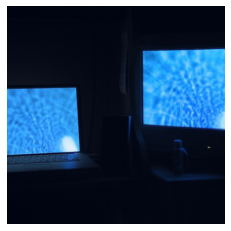

Random Image:  22   ['tvmonitor']
Nearest neighbor:  2584  Label:  ['tvmonitor']
Nearest neighbor:  853  Label:  ['tvmonitor']
Nearest neighbor:  4687  Label:  ['tvmonitor']
Nearest neighbor:  332  Label:  ['person', 'tvmonitor']


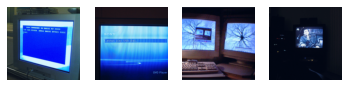

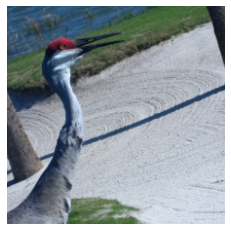

Random Image:  33   ['bird']
Nearest neighbor:  2157  Label:  ['dog']
Nearest neighbor:  4017  Label:  ['bird']
Nearest neighbor:  2736  Label:  ['bird']
Nearest neighbor:  241  Label:  ['bird']


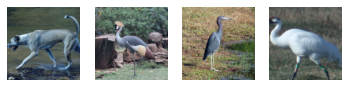

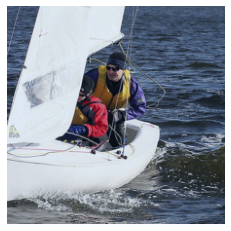

Random Image:  56   ['boat', 'person']
Nearest neighbor:  226  Label:  ['boat', 'person']
Nearest neighbor:  3140  Label:  ['boat', 'person']
Nearest neighbor:  2100  Label:  ['boat', 'person']
Nearest neighbor:  3007  Label:  ['boat', 'person']


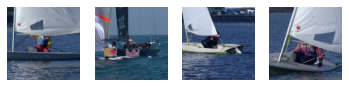

In [5]:
for ind in random_images:
    img = output_total_resnet[ind,:].reshape(1,-1)

    img_n_dist, img_n_index = neighbor_resnet.kneighbors(img)
    img, label, _ = test_loader.dataset.__getitem__(ind)

    img = img.permute(1,2,0).numpy()
    img = (img-img.min())/(img.max()-img.min())
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    labels = label.numpy().nonzero()[0]
    label_name = []
    for label in labels:
        label_name.append(test_loader.dataset.get_class_name(label))
    print("Random Image: ", ind, " ",label_name)
    img_grid = []
    for indices in img_n_index[0][1:]:
        img_nn, label, _ = test_loader.dataset.__getitem__(indices)
        img_nn = img_nn.permute(1,2,0).numpy()
        img_grid.append((img_nn-img_nn.min())/(img_nn.max()-img_nn.min()))
        labels = label.numpy().nonzero()[0]
        label_name = []
        for label in labels:
            label_name.append(test_loader.dataset.get_class_name(label))
        print("Nearest neighbor: ", indices, " Label: ", label_name)
    f, axarr = plt.subplots(1, 4)
    plt.axis('off')
    axarr[0].imshow(img_grid[0])
    axarr[1].imshow(img_grid[1])
    axarr[2].imshow(img_grid[2])
    axarr[3].imshow(img_grid[3])
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[3].axis('off')



In [3]:
# caffenet
from models_eval import CaffeNetPool5
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
caffe_pool5 = CaffeNetPool5().to(device)
model_name='caffenet3'
epoch=50
path = 'model_params/checkpoint-{}-epoch{}.pth'.format(
        model_name, epoch)
caffe_pool5.load_state_dict(torch.load(path, map_location=device))
caffe_pool5.eval()

args = ARGS(epochs=10, lr=0.0001, batch_size=32, test_batch_size=128, gamma=0.75, step_size=5, save_at_end=True, save_freq=-1, use_cuda=True)
args.test_batch_size=1
test_loader = utils.get_data_loader(
        'voc', train=False, batch_size=args.test_batch_size, split='test', inp_size=args.inp_size)
features_caffe = None
with torch.no_grad():
    for batch_idx, (data, target, wgt) in enumerate(test_loader):
        data, target, wgt = data.to(device), target.to(device), wgt.to(device)
        output = caffe_pool5(data)
        if features_caffe is None:
            features_caffe = output.cpu().detach().numpy()
        else:
            features_caffe = np.concatenate((features_caffe, output.cpu().detach().numpy()), axis=0)

print(batch_idx)
print(features_caffe.shape)
features_caffe = features_caffe.reshape(len(test_loader.dataset), -1)
print(features_caffe.shape)

4951
(4952, 256, 5, 5)
(4952, 6400)


In [10]:
from sklearn.neighbors import NearestNeighbors
neighbor_caffe = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
neighbor_caffe.fit(features_caffe)

random_images_caffe = [59, 10, 156]

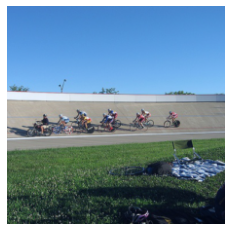

Random Image:  59   ['bicycle', 'chair', 'motorbike', 'person']
Nearest neighbor:  3410  Label:  ['bicycle', 'person']
Nearest neighbor:  2816  Label:  ['train']
Nearest neighbor:  437  Label:  ['person']
Nearest neighbor:  4002  Label:  ['train']


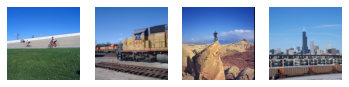

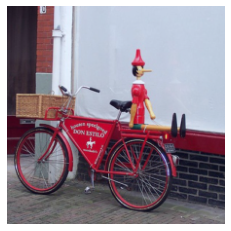

Random Image:  10   ['bicycle']
Nearest neighbor:  72  Label:  ['bottle', 'chair', 'diningtable', 'person']
Nearest neighbor:  4860  Label:  ['person']
Nearest neighbor:  2583  Label:  ['chair', 'diningtable', 'pottedplant']
Nearest neighbor:  651  Label:  ['chair', 'diningtable']


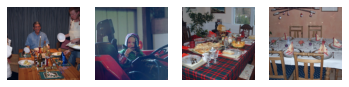

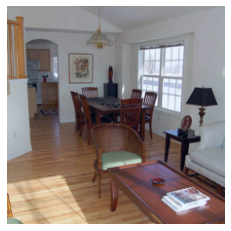

Random Image:  156   ['chair', 'diningtable', 'sofa']
Nearest neighbor:  4697  Label:  ['chair', 'sofa']
Nearest neighbor:  4818  Label:  ['chair', 'diningtable']
Nearest neighbor:  3171  Label:  ['chair']
Nearest neighbor:  1370  Label:  ['chair', 'pottedplant']


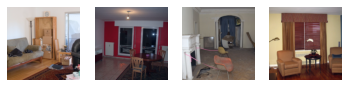

In [11]:
for ind in random_images_caffe:
    img = features_caffe[ind,:].reshape(1,-1)

    img_n_dist, img_n_index = neighbor_caffe.kneighbors(img)
    img, label, _ = test_loader.dataset.__getitem__(ind)

    img = img.permute(1,2,0).numpy()
    img = (img-img.min())/(img.max()-img.min())
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    labels = label.numpy().nonzero()[0]
    label_name = []
    for label in labels:
        label_name.append(test_loader.dataset.get_class_name(label))
    print("Random Image: ", ind, " ",label_name)
    img_grid = []
    for indices in img_n_index[0][1:]:
        img_nn, label, _ = test_loader.dataset.__getitem__(indices)
        img_nn = img_nn.permute(1,2,0).numpy()
        img_grid.append((img_nn-img_nn.min())/(img_nn.max()-img_nn.min()))
        labels = label.numpy().nonzero()[0]
        label_name = []
        for label in labels:
            label_name.append(test_loader.dataset.get_class_name(label))
        print("Nearest neighbor: ", indices, " Label: ", label_name)
    f, axarr = plt.subplots(1, 4)
    plt.axis('off')
    axarr[0].imshow(img_grid[0])
    axarr[1].imshow(img_grid[1])
    axarr[2].imshow(img_grid[2])
    axarr[3].imshow(img_grid[3])
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[3].axis('off')

## 5.2 t-SNE visualization of intermediate features (7pts)
We can also visualize how the feature representations specialize for different classes. Take 1000 random images from the test set of PASCAL, and extract caffenet (scratch) fc7 features from those images. Compute a 2D [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection of the features, and plot them with each feature color coded by the GT class of the corresponding image. If multiple objects are active in that image, compute the color as the ”mean” color of the different classes active in that image. Legend the graph with the colors for each object class.

In [12]:
# caffenet fc7
from models_eval import CaffeNetFC7
import utils
from utils import ARGS
import numpy as np
from models_eval import CaffeNetFC7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
caffe_fc7 = CaffeNetFC7().to(device)
model_name='caffenet2'
epoch=50
path = 'model_params/checkpoint-{}-epoch{}.pth'.format(
        model_name, epoch)
caffe_fc7.load_state_dict(torch.load(path, map_location=device))
caffe_fc7.eval()
# dicts = model.state_dict()
# pool5 = model.get_pool5()
# print(pool5.numpy())
# for key,value in dicts.items():
#   print(key)
args = ARGS(epochs=10, lr=0.0001, batch_size=32, test_batch_size=128, gamma=0.75, step_size=5, save_at_end=True, save_freq=-1, use_cuda=True)
args.test_batch_size=250
test_loader = utils.get_data_loader(
        'voc', train=False, batch_size=args.test_batch_size, split='test', inp_size=args.inp_size)
features = None
labels = None
i=0
with torch.no_grad():
    for batch_idx, (data, target, wgt) in enumerate(test_loader):
        i = i+1
        # TODO Q1.3: insert your code here
        # print(batch_idx, data.shape)

        data, target, wgt = data.to(device), target.to(device), wgt.to(device)
        output = caffe_fc7(data)
        if features is None:
            features = output.cpu().detach().numpy()
            labels = target.cpu().detach().numpy()
        else:
            features = np.concatenate((features, output.cpu().detach().numpy()), axis=0)
            labels = np.concatenate((labels, target.cpu().detach().numpy()), axis=0)

        if i>=4:
                break
        # output_total = np.append(output_total, output.cpu().detach().numpy())
        # print(output.shape, output_total.shape)


print(batch_idx)
print(features.shape)

3
(1000, 4096)


In [13]:
# plot t-SNE here
from sklearn.manifold import TSNE
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(features)
tsne_result.shape

/home/unanditha02/anaconda3/envs/dl-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/unanditha02/anaconda3/envs/dl-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1000, 2)

In [14]:
# print(labels.shape)
# print(labels[0])
# print(type(labels[0].nonzero()[0]))
# y = np.zeros(len(labels))
y = []
for i in range(len(labels)):
    mean_label = 0
    num_labels = len(labels[i].nonzero()[0])
    for label in labels[i].nonzero()[0]:
        # print(label)
        mean_label = (mean_label + label)
    mean_label = mean_label/num_labels
    label= test_loader.dataset.get_class_name(int(mean_label))
    # y[i] = label
    y.append(label)

# print("mean: ",y)


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

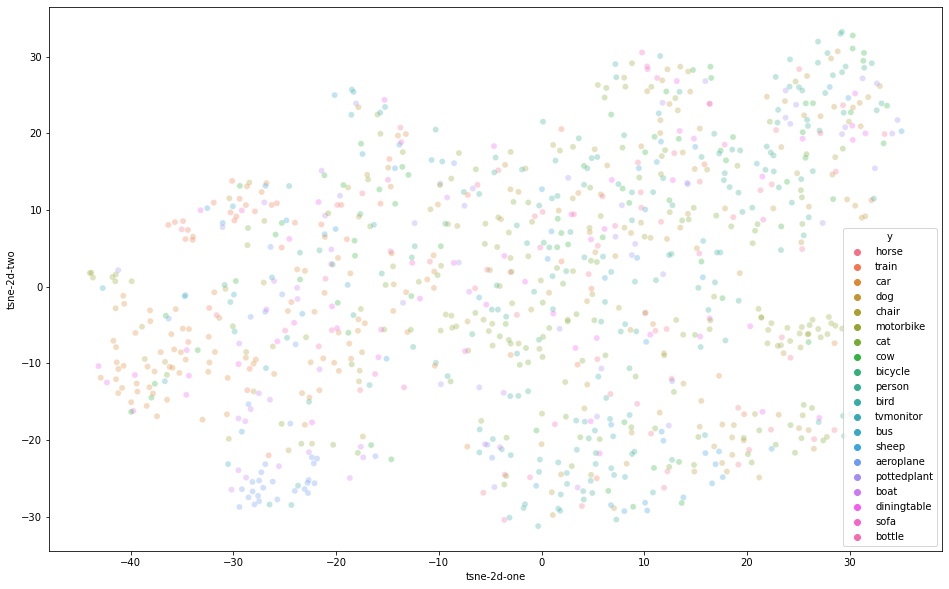

In [15]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame()
# print(labels.shape)
df['tsne-2d-one'] = tsne_result[:,0]
df['tsne-2d-two'] = tsne_result[:,1]
df['y'] = y
# print(tsne_result[:,0].shape, tsne_result[:,1].shape, y.shape)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    # palette=sns.color_palette("icefire", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)

## 5.3 Are some classes harder? (6pts)
Show the per-class performance of your caffenet (scratch) and ResNet (finetuned) models. This is an open-ended question and you may use any performance metric that makes sense. Try to explain, by observing examples from the dataset, why some classes are harder or easier than the others (consider the easiest and hardest class). Do some classes see large gains due to pre-training? Can you explain why that might happen?

**YOUR ANSWER HERE**

In [16]:
#  caffenet
import utils
from utils import ARGS
import numpy as np
from models_eval import CaffeNet53

args = ARGS(epochs=10, lr=0.0001, batch_size=32, test_batch_size=128, gamma=0.75, step_size=5, save_freq=-1, use_cuda=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
caffe_53 = CaffeNet53().to(device)
test_loader = utils.get_data_loader(
        'voc', train=False, batch_size=args.test_batch_size, split='test', inp_size=args.inp_size)
model_name='caffenet2'
epoch=50
path = 'model_params/checkpoint-{}-epoch{}.pth'.format(
        model_name, epoch)
caffe_53.load_state_dict(torch.load(path, map_location=device))

caffe_53.eval()
ap, map = utils.eval_dataset_map(caffe_53, args.device, test_loader)

# print(ap.shape)
# print(features.shape)



20


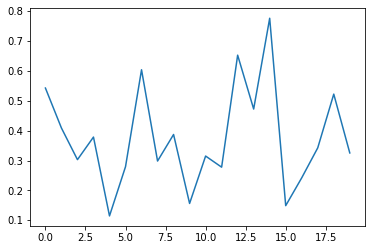

In [17]:
print(len(ap))
n = np.arange(0, 20)
# plt.plot(VOCDataset.CLASS_NAMES, ap)
plt.plot(n, ap)

In [18]:
#  resnet
import utils
from utils import ARGS
import numpy as np
from models_eval import CaffeNet53

args = ARGS(epochs=10, lr=0.0001, batch_size=32, test_batch_size=128, gamma=0.75, step_size=5, save_freq=-1, use_cuda=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True).to(device)
resnet.eval()
ap, map = utils.eval_dataset_map(resnet, args.device, test_loader)


20


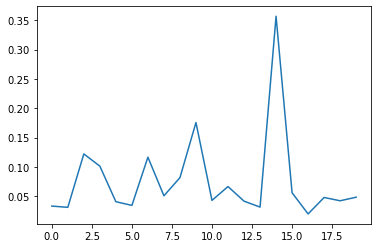

In [12]:
print(len(ap))
n = np.arange(0, 20)
# plt.plot(VOCDataset.CLASS_NAMES, ap)
plt.plot(n, ap)